In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [16]:
# Image normalization
# Converts the image into a tesor and normalizes to acheive a mean of 0 and variance of 1
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# Download MNIST train and test set and normalize images
train_set = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Define train and test dataloaders, used to get batches sequentially
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
class FilterBank(nn.Module):
    def __init__(self, in_dim, out_dim, K):
        super(FilterBank, self).__init__()

        # Filter Bank with num_filter filters and num_taps taps
        self.conv = nn.Conv2d(in_channels = in_dim, out_channels = out_dim, kernel_size = 2*K+1, stride = 1, padding = 'same')
        if out_dim == 7 and K == 1:
          self.conv.weight.data = torch.stack(
              (torch.ones(3,3).unsqueeze(0).to(device),
               torch.Tensor([-1, 0, 1]).repeat(3, 1).unsqueeze(0).to(device),
               torch.Tensor([[-1, 0, 1]]).T.repeat(1, 3).unsqueeze(0).to(device),
               torch.stack((torch.Tensor([-1, -2, -1]), torch.Tensor([0, 0, 0]), torch.Tensor([1, 2, 1])),dim=0).unsqueeze(0).to(device),
               torch.stack((torch.Tensor([-1, -2, -1]), torch.Tensor([0, 0, 0]), torch.Tensor([1, 2, 1])), dim=1).unsqueeze(0).to(device),
               torch.stack((torch.Tensor([-2, -1, 0]), torch.Tensor([-1, 0, 1]), torch.Tensor([0, 1, 2])),dim=0).unsqueeze(0).to(device),
               torch.stack((torch.Tensor([0, 1, 2]), torch.Tensor([-1, 0, 1]), torch.Tensor([-2, -1, 0])),dim=0).unsqueeze(0).to(device)
               )

          ).float()


    def forward(self, x):
        x = self.conv(x)
        return x

In [40]:
class ReadoutLayer(nn.Module):
    def __init__(self, input_length, classes):
        super().__init__()
        self.filter = torch.nn.Parameter(torch.empty((classes, input_length)))
        nn.init.xavier_normal_(self.filter)

    def forward(self,x):
        return x @ self.filter.T

class SpatialCNN(nn.Module):
  def __init__(self, L, taps, features, pool):
    super().__init__()
    assert(len(features) - 1 == L)
    assert(len(taps) == L)
    assert(len(pool) - 1 == L)
    models = []
    for i in range(L):
      models.append(FilterBank(features[i], features[i+1], taps[i]))
      models.append(nn.AvgPool2d(int(pool[i]/pool[i+1])))
      models.append(nn.Dropout2d(p=0.01))
      models.append(nn.ReLU())
    models.append(nn.Flatten())
    models.append(ReadoutLayer(pool[-1]*pool[-1]*features[-1],10))
    self.model = nn.Sequential(*models)

  def forward(self, x):
      return self.model(x)


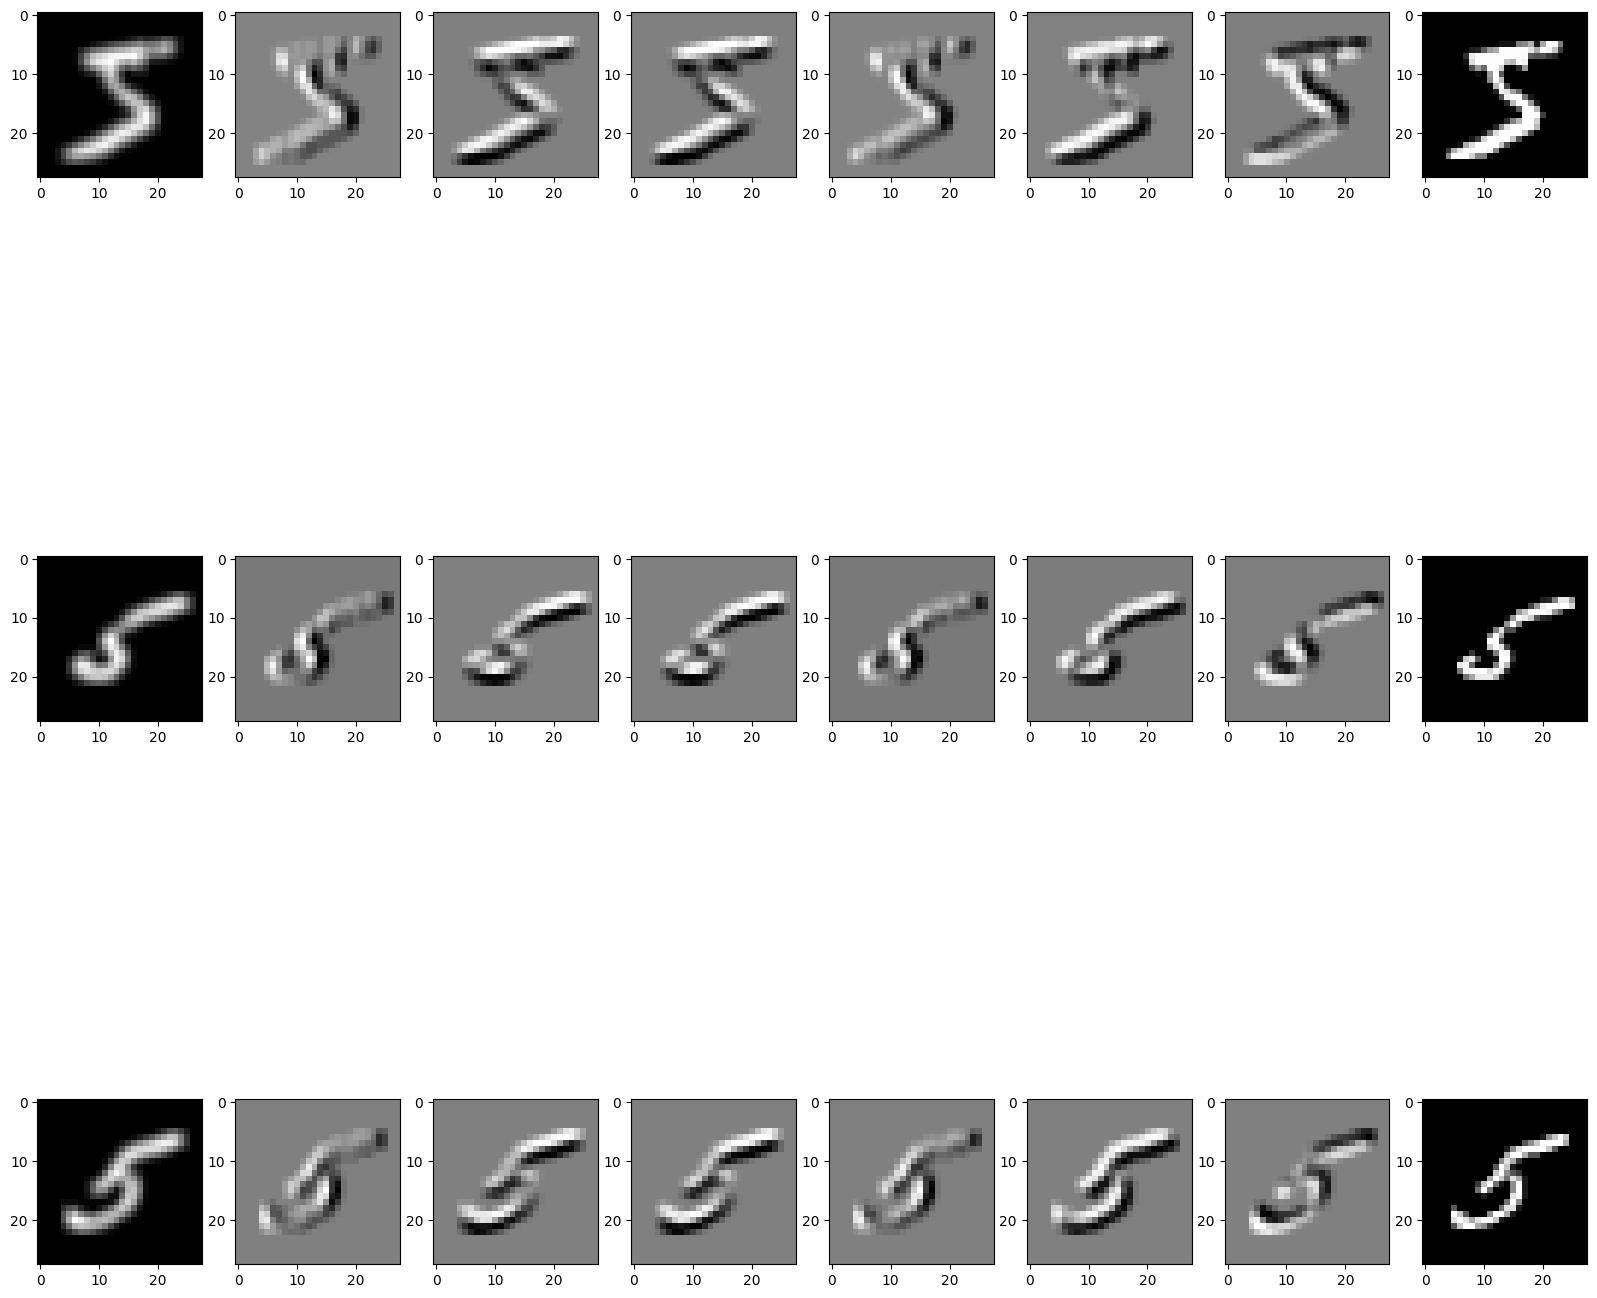

In [41]:
model = FilterBank(1, 7, 1).to(device)
idxs = train_loader.dataset.targets == 5
images = train_loader.dataset.data[idxs]
images = torch.squeeze(images[:3]).float()
pred = model(images.unsqueeze(1).to(device)).to('cpu').detach()

f, axis = plt.subplots(3,8, figsize=(20, 20))
for i in range(3):
  for j in range(8):
    if j == 7:
      axis[i,j].imshow(images[i], cmap = 'binary_r')
    else:
      axis[i,j].imshow(pred[i][j], cmap = 'binary_r')

In [42]:
model = SpatialCNN(3, [1,2,1], [1,3,7,10], [28,28,14,7]).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
cross_entropy = nn.CrossEntropyLoss()

In [43]:
loss_evol = []
num_epochs = 8
for epoch in range(num_epochs):
    loss_epoch = 0.
    acc_epoch = 0.

    for data, target in train_loader:
        # Clear gradients of previous batch
        optimizer.zero_grad()

        # Compute batch predictions
        output = model(data.to(device))

        # Compute loss
        loss = cross_entropy(output, target)

        # Compute gradients of loss w respect to current params
        loss.backward()

        # Update params using SGD
        optimizer.step()

        # Accumulate batch losses
        loss_epoch += loss.item()

        # Accumulate correct predictions, highest score is predicted class.
        pred = output.argmax(dim=-1)
        acc_epoch += torch.sum(pred == target)

    loss_evol.append(loss_epoch/len(train_loader))
    # Print metrics
    print(f"Epoch: {epoch} \t Loss: {loss_epoch/len(train_loader):.3f} \t Acc: {acc_epoch*100/len(train_loader.dataset):.2f}")

Epoch: 0 	 Loss: 1.825 	 Acc: 33.55
Epoch: 1 	 Loss: 0.428 	 Acc: 87.06
Epoch: 2 	 Loss: 0.316 	 Acc: 90.57
Epoch: 3 	 Loss: 0.264 	 Acc: 92.16
Epoch: 4 	 Loss: 0.226 	 Acc: 93.28
Epoch: 5 	 Loss: 0.198 	 Acc: 94.12
Epoch: 6 	 Loss: 0.177 	 Acc: 94.76
Epoch: 7 	 Loss: 0.159 	 Acc: 95.31


In [44]:
test_loss_evol = []
num_epochs = 1
for epoch in range(num_epochs):
    loss_epoch = 0.
    acc_epoch = 0.

    for data, target in test_loader:
        output = model(data.to(device))
        loss = cross_entropy(output, target)
        loss_epoch += loss.item()
        pred = output.argmax(dim=-1)
        acc_epoch += torch.sum(pred == target)

    loss_evol.append(loss_epoch/len(test_loader))
    # Print metrics
    print(f"Epoch: {epoch} \t Loss: {loss_epoch/len(test_loader):.3f} \t Acc: {acc_epoch*100/len(test_loader.dataset):.2f}")

Epoch: 0 	 Loss: 0.146 	 Acc: 95.55
